In [1]:
import pandas as pd
import re
import numpy as np
# from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import matplotlib
from bs4 import BeautifulSoup
import urllib
from pprint import pprint
import pickle
import os
from collections import Counter
import nltk
import random
from html.parser import HTMLParser
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import string
from scipy.sparse import csr_matrix, vstack

import fasttext as ft
import spacy

# Get n most recent posts in halfday from blogs that have descriptions

In [2]:
halfday = pd.read_pickle('/usr0/home/mamille2/tumblr/data/halfday_text.pkl')
print(halfday.columns)

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'restrictedtags_200freq'],
      dtype='object')


In [3]:
# Load tumblog_ids of blogs with descriptions
with open('/usr0/home/mamille2/tumblr/data/endesc_ids.txt', 'r') as f:
    desc_ids = [int(i) for i in f.read().splitlines()]
    
len(desc_ids)

4617128

In [4]:
# Filter halfday text to just blogs with descriptions
halfday_desc = halfday[halfday['tumblog_id'].isin(desc_ids)]
len(halfday_desc)

79208

In [5]:
# Group by tumblog id
counts = halfday_desc.groupby('tumblog_id').size()

counts10 = counts[counts>=10]
len(counts10)

1653

In [7]:
counts5 = counts[counts>=5]
len(counts5)

4082

In [11]:
counts5.index.tolist()

[1499632.0,
 2540273.0,
 3342503.0,
 3997000.0,
 4662167.0,
 4817350.0,
 5705140.0,
 6380698.0,
 6913993.0,
 6949889.0,
 7910888.0,
 8713243.0,
 8800956.0,
 9813757.0,
 10040194.0,
 10300522.0,
 12414133.0,
 12498621.0,
 12531264.0,
 12800148.0,
 12860354.0,
 12963387.0,
 14193638.0,
 14542289.0,
 16774040.0,
 16914773.0,
 17219612.0,
 17615185.0,
 18185604.0,
 18570770.0,
 18975590.0,
 19073302.0,
 20052888.0,
 20240442.0,
 20531297.0,
 20955829.0,
 21042769.0,
 21071272.0,
 24017767.0,
 24027529.0,
 24417548.0,
 25062764.0,
 26113679.0,
 26293553.0,
 26367165.0,
 26371591.0,
 26424172.0,
 26675205.0,
 26848090.0,
 27268511.0,
 28827993.0,
 29729968.0,
 30123576.0,
 30380955.0,
 30907346.0,
 31225704.0,
 32415796.0,
 32978689.0,
 33014783.0,
 33063736.0,
 33226728.0,
 33285642.0,
 33413370.0,
 33962394.0,
 34417916.0,
 34510836.0,
 34521290.0,
 34908059.0,
 35289037.0,
 35364515.0,
 35375285.0,
 36109820.0,
 36263260.0,
 36538429.0,
 37957474.0,
 38870004.0,
 38872244.0,
 39357884.0,


In [12]:
halfday_desc5 = halfday_desc[halfday_desc['tumblog_id'].isin(counts5.index.tolist())]
len(halfday_desc5)

53283

In [14]:
# Restrict to 5 most recent text posts

# Sort by tumblog_id, timestamp
halfday_desc5.sort_values(['tumblog_id', 'activity_time_epoch'], inplace=True, ascending=False)
halfday_desc5['activity_time_epoch']

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


1600192    1.488887e+12
2770100    1.488887e+12
2831138    1.488887e+12
798793     1.488887e+12
3015164    1.488886e+12
2952736    1.488885e+12
1105064    1.488884e+12
1291748    1.488887e+12
2277548    1.488887e+12
2338803    1.488887e+12
1475480    1.488885e+12
57807      1.488883e+12
57800      1.488883e+12
1658608    1.488883e+12
2705331    1.488883e+12
2890491    1.488884e+12
1165118    1.488882e+12
2519809    1.488882e+12
1781194    1.488882e+12
2273701    1.488881e+12
1903333    1.488880e+12
2887990    1.488880e+12
1468014    1.488875e+12
2272261    1.488879e+12
2272221    1.488879e+12
178445     1.488879e+12
669103     1.488878e+12
2086482    1.488878e+12
1408410    1.488877e+12
1408353    1.488877e+12
               ...     
699004     1.488856e+12
1314131    1.488856e+12
1375423    1.488855e+12
812816     1.488851e+12
1922139    1.488851e+12
2229969    1.488851e+12
997307     1.488851e+12
381708     1.488851e+12
2783323    1.488851e+12
2290923    1.488851e+12
1535794    1.488

In [15]:
halfday_desc.groupby('tumblog_id').head(5).reset_index(drop=True) # for some reason some tumblog_ids have less than 5 rows

,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,...,post_classifier,blog_classifier,accepts_answers,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,mentions,post_tags,restrictedtags_200freq
0,123961888588,1.488870e+12,244421030.0,◆台灣集中市場漲跌幅前30名,https://tmblr.co/ZM_Y1k1pSj4zC,text,NaN,html,0.0,1.436771e+12,...,safe,safe,False,NaN,[],-1.000000e+00,<p>鉅亨台北資料中心</p><pre>台北‧03月06日 交易日 <br/><br/>◆...,{},"{(_lmsid:a0770000005DBaDAAW),(_uuid:3f4abea9-d...",[]
1,123966010483,1.488876e+12,244421030.0,◆台灣集中市場投信近3日買賣超前30名,https://tmblr.co/ZM_Y1k1pSypHp,text,NaN,html,0.0,1.436776e+12,...,safe,safe,False,NaN,[],-1.000000e+00,<p>鉅亨台北資料中心</p><pre>台北‧03月06日 交易日 <br/><br/>◆...,{},"{(_lmsid:a0770000005DBaDAAW),(_author:鉅亨台北資料中心...",[]
2,123966789353,1.488876e+12,244421030.0,◆台灣店頭市場自營商買賣超前30名,https://tmblr.co/ZM_Y1k1pS-nRf,text,NaN,html,0.0,1.436778e+12,...,safe,safe,False,NaN,[],-1.000000e+00,<p>鉅亨台北資料中心</p><pre>台北‧03月06日 交易日 <br/><br/>◆...,{},"{(_uuid:64fe4942-eed6-34da-ac44-213e5d0c5c37),...",[]
3,127673435483,1.488846e+12,244421030.0,期貨(不含選擇權)三大法人多空淨額,https://tmblr.co/ZM_Y1k1svxWLR,text,NaN,html,0.0,1.440635e+12,...,safe,safe,False,NaN,[],-1.000000e+00,<p>鉅亨台北資料中心</p><pre>台北．03月03日 交易日<br/><br/>法人別...,{},"{(_lmsid:a0770000005DBaDAAW),(_author:鉅亨台北資料中心...",[]
4,129499584749,1.488862e+12,216251892.0,NaN,https://tmblr.co/Z8D0jl1ucnjZj,text,NaN,html,28299.0,1.442766e+12,...,safe,safe,False,1.294992e+11,"[root_post_id#86550962167,root_post_blog_id#18...",8.655096e+10,"<p><a class=""tumblr_blog"" href=""http://mulderf...",{},"{(ME),(ALIENS),(space)}","[ME, space]"
5,142525405455,1.488845e+12,145303553.0,"Aang, Katara, and anger",https://tmblr.co/Zy3d9l24lBHaF,text,NaN,html,608.0,1.460227e+12,...,safe,safe,False,1.388062e+11,"[root_post_id#138806192727,root_post_blog_id#4...",1.388062e+11,"<p><a class=""tumblr_blog"" href=""http://quentyl...",{},"{(atla),(aang),(katara),(commentary),(commenta...",[atla]
6,143887532986,1.488856e+12,238309218.0,The Ultimate Dessert Guide: Mega Fashion Hall ...,https://tmblr.co/ZQ7tOk260NOEw,text,NaN,html,1.0,1.462445e+12,...,safe,safe,False,NaN,[],-1.000000e+00,"<div class=""ttr_start""></div><p>With the new M...",{},"{(_revsp:insights.looloo.com),(_lmsid:a0Vd0000...",[]
7,143887532986,1.488865e+12,238309218.0,The Ultimate Dessert Guide: Mega Fashion Hall ...,https://tmblr.co/ZQ7tOk260NOEw,text,NaN,html,1.0,1.462445e+12,...,safe,safe,False,NaN,[],-1.000000e+00,"<div class=""ttr_start""></div><p>With the new M...",{},"{(_revsp:insights.looloo.com),(_lmsid:a0Vd0000...",[]
8,143887532986,1.488879e+12,238309218.0,The Ultimate Dessert Guide: Mega Fashion Hall ...,https://tmblr.co/ZQ7tOk260NOEw,text,NaN,html,1.0,1.462445e+12,...,safe,safe,False,NaN,[],-1.000000e+00,"<div class=""ttr_start""></div><p>With the new M...",{},"{(_revsp:insights.looloo.com),(_lmsid:a0Vd0000...",[]
9,154485637994,1.488850e+12,313629641.0,IM 👏PROUD👏 OF 👏CHRIS 👏FOR 👏NOT 👏CUMMING 👏ON 👏T...,https://tmblr.co/ZpLYvf2Fu3yDg,text,NaN,html,7951.0,1.481763e+12,...,safe,safe,False,1.544856e+11,"[root_post_id#154481776575,root_post_blog_id#6...",1.544818e+11,NaN,{},"{(yoi),(ssame),(01)}",[yoi]


# Get fasttext word embeddings for blog descriptions

In [2]:
wd_embed = ft.load_model('/usr0/home/mamille2/fasttext/en_wiki_stanford_model_300.bin')

In [38]:
# Load Tumblr blog descriptions
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
print(len(data))
print(data['tokenized_blog_description'].dtype)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,9,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4617128
object


## Tokenize blog descriptions

In [6]:
nlp = spacy.load('en')

In [34]:
# Tokenize with nltk

blog_descs_toks = []

for desc in tqdm(blog_descs):
    toks = nltk.word_tokenize(desc.lower())
    blog_descs_toks.append(toks)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

In [77]:
# Tokenize with spaCy

blog_descs_toks = []

for desc in tqdm(blog_descs):
    toks = [tok.text for tok in nlp.tokenizer(desc.lower())]
    blog_descs_toks.append(toks)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

## Save out tokenized descriptions

In [78]:
data['tokenized_blog_description'] = blog_descs_toks
type(data.loc[1,'tokenized_blog_description'])

list

In [79]:
data.to_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')

## Get restricted vocab and fasttext vectors for restricted vocab

In [5]:
# Load tokenized data

data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
blog_descs_toks = data['tokenized_blog_description'].tolist()
print(len(data))

4617128


In [4]:
vocab = {}
vocab_ctr = Counter([tok for desc in blog_descs_toks for tok in desc])
print(len(vocab_ctr))

vocab[100000] = set([wd for wd,_ in vocab_ctr.most_common(100000)])
print(vocab_ctr.most_common(10))

1744233
[('.', 1844836), ('i', 1118802), ('and', 723453), ('a', 715065), ('the', 637033), ('to', 619058), ('my', 514771), ('!', 500725), ('is', 432320), ('of', 418484)]


In [5]:
# Save out vocab
with open('/usr0/home/mamille2/tumblr/data/desc_vocab100000.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [3]:
# Load vocab
with open('/usr0/home/mamille2/tumblr/data/desc_vocab100000.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [4]:
# Get fasttext vectors for restricted vocab
wordvec = {}
wordvec[100000] = {}
for v in vocab[100000]:
    wordvec[100000][v] = wd_embed[v]
    
len(wordvec[100000])

100000

In [5]:
# Save out vectors for restricted vocab
with open('/usr0/home/mamille2/tumblr/data/desc_ftvecs100000.pkl', 'wb') as f:
    pickle.dump(wordvec, f)

## See lengths of blog descriptions

In [53]:
desc_lens = data['tokenized_blog_description'].map(lambda x: len(x)).values
len(desc_lens)

4617128

In [54]:
print(np.mean(desc_lens))
print(np.std(desc_lens))
print(max(desc_lens))
print(min(desc_lens))

8.39860276778
23.4869702256
21845
0


## Save description embeddings

In [6]:
# Load vectors for restricted vocab
with open('/usr0/home/mamille2/tumblr/data/desc_ftvecs100000.pkl', 'rb') as f:
    wordvec = pickle.load(f)

In [18]:
MAX_WORD_LEN = 50
EMBED_LEN = 300

unkvec = np.mean(np.array(list(wordvec[100000].values())), axis=0) # unk vector as avg
unkvec.shape

(300,)

In [29]:
# def desc2mat(desc_toks, wordvecs, unkvec):
# def desc2mat(desc_toks):
    
#     # fill in w word vectors
#     desc_mat = np.array([wordvec[100000].get(tok, unkvec) for tok in desc[:MAX_WORD_LEN]])

#     # pad to get to 50 words
#     desc_mat = np.pad(desc_mat, ((0, MAX_WORD_LEN - desc_mat.shape[0]), (0,0)), 'constant', constant_values=0)

#     return desc_mat

def desc2vec(desc_toks):
    
    # averaged word vectors
    desc_vec = np.mean(np.array([wordvec[100000].get(tok, unkvec) for tok in desc_toks[:MAX_WORD_LEN]]), axis=0)
    
    return desc_vec
    
    # concatenated word vectors
    # fill in w word vectors
#     desc_vec = np.array([wordvec[100000].get(tok, unkvec) for tok in desc_toks[:MAX_WORD_LEN]]).ravel()

#     # pad to get to 50 words
#     desc_vec = np.pad(desc_vec, ((0, EMBED_LEN*MAX_WORD_LEN - desc_vec.shape[0])), 'constant', constant_values=0)

# #     return desc_vec
#     return csr_matrix(desc_vec)

In [31]:
desc2vec(tokenized_descs[0]).shape

(300,)

In [32]:
desc_embeds = []

# for desc in tqdm(data['tokenized_blog_description'].tolist()[:3]):
# desc = data['tokenized_blog_description'].tolist()[2]
tokenized_descs = data['tokenized_blog_description'].tolist()

# for desc in tqdm(tokenized_descs[:1000]):
for desc in tqdm(tokenized_descs): # would take forever
#     desc_embeds = vstack([desc_embeds, desc2vec(desc)])
    desc_embeds.append(desc2vec(desc))

# pool = Pool(30)
# pool.map(desc2mat, tokenized_descs)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [33]:
descs_emb = np.array(desc_embeds)
descs_emb.shape

(4617128, 300)

In [34]:
# Save description embeddings
outpath = '/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy'

np.save(outpath, descs_emb)

In [ ]:
descs_emb = vstack(desc_embeds)
descs_emb.shape

In [ ]:
%xdel desc_embeds

In [ ]:
# Save description embeddings
outpath = '/usr0/home/mamille2/tumblr/data/desc_embeddings.npz'

scipy.sparse.save_npz(outpath, descs_emb)

# Print out blog description tumblog_ids

In [43]:
with open('/usr0/home/mamille2/tumblr/data/endesc_ids.txt', 'w') as f:
    for id in data['tumblog_id'].tolist():
        f.write(str(int(id)) + '\n')

# Filter blog description data

In [ ]:
# Remove blog descriptions with no ASCII chars
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
len(data)

In [5]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [6]:
ascii_data = data[data['parsed_blog_description'].map(lambda x: any([c in string.printable for c in x]))]
len(ascii_data)

4617128

In [8]:
'★인생역전이벤트진행중★' in ascii_data['parsed_blog_description'].tolist()

False

In [9]:
ascii_data.to_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv', index=False)

In [3]:
# Remove nans from parsed en_nan blog descs
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_nan_blog_descriptions.csv')
len(data)

6346197

In [4]:
# Build just en blog descriptions
en_data = data[data['language'].map(lambda x: str(x).startswith('en'))]
len(en_data)

4755354

In [5]:
en_data.to_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv', index=False)

In [4]:
data = data[data['parsed_blog_description'].map(lambda x: isinstance(x, str) and len(x)>0)]
len(data)

6346197

In [6]:
data.to_csv('/usr0/home/mamille2/tumblr/data/en_nan_blog_descriptions.csv', index=False)

In [4]:
# Load data
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/blog_descs_all.csv')

In [5]:
data.columns

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date'],
      dtype='object')

In [12]:
len(data)

10153183

In [ ]:
en_data = data[data['language'].map(lambda x: str(x).startswith('en') or isinstance(x, float))]
en_data = en_data[en_data['tumblog_id'].map(lambda x: not np.isnan(x))]
# en_data = data[data['language'].map(lambda x: str(x).startswith('en'))]
print(len(en_data))

In [26]:
en_data[en_data['tumblr_blog_description'].map(lambda x: isinstance(x, float))].head()

,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date
84748,143733349.0,1.489831e+12,thejasonborneposts-blog,NaN,NaN,https://thejasonborneposts-blog.tumblr.com/,NaN,false,true,false,1383031024000,1489831209000,US/Eastern,en_US,safe,20171119
89949,164866196.0,1.489784e+12,yourvictoriabrunome,NaN,NaN,https://yourvictoriabrunome.tumblr.com/,NaN,false,true,false,1389130544000,1489784429000,US/Eastern,en_US,safe,20171119
543397,116289680.0,1.444007e+12,airrugebregt,air rugebregt,NaN,http://airrugebregt.tumblr.com/,NaN,false,true,false,1371545979000,1439980539000,US/Eastern,en_US,NaN,20171115
655105,282553253.0,1.489845e+12,thismightsuffice,this might suffice,NaN,https://thismightsuffice.tumblr.com/,NaN,false,true,false,1457075679000,1489845107000,US/Eastern,en_US,safe,20171115
701265,331331423.0,1.484512e+12,vibeaheadoftime,NaN,NaN,https://vibeaheadoftime.tumblr.com/,NaN,false,true,false,1484380750000,1484512077000,US/Eastern,en_US,safe,20171115


In [28]:
en_data = en_data[en_data['tumblr_blog_description'].map(lambda x: isinstance(x, str) and len(x) > 0)]
len(en_data)

6571709

In [22]:
en_data.loc[:5, ['tumblog_id', 'tumblr_blog_name', 'tumblr_blog_title', 'language', 'tumblr_blog_description']]

,tumblog_id,tumblr_blog_name,tumblr_blog_title,language,tumblr_blog_description
0,1228.0,buenafe-blog,quick photos,en_US,This is a quick blog
1,3224.0,jww-blog,JWW tumblr,en_US,...
2,4223.0,snurks-blog,snurks,en_US,Call 206-312-4SNURKS to leave a message.
3,5224.0,wowthisisreallylongandthing-blog,longsojsdjfkl,en_US,asdflkasjflk
4,6220.0,mediacogs,Media Cogs,NaN,The Visual Stuff Around My Head
5,9220.0,blindot-blog,Blindot,en_US,This is not so clear


# Format blog descriptions

In [2]:
en_data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
len(en_data)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,9,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4617128

In [4]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

In [5]:
en_data['parsed_blog_description'] = en_data['tumblr_blog_description'].map(strip_tags)

In [9]:
pd.set_option('display.max_colwidth', 999)

In [10]:
en_data.loc[:, ['parsed_blog_description']]

,parsed_blog_description
0,This is a quick blog
1,This makes no CENTS Go Figure
2,Call 206-312-4SNURKS to leave a message.
3,asdflkasjflk
4,This is not so clear
5,random musings
6,this is the tumblr for Matthew Brady Clark photos | wearetheclarks.com | temp design portfolio
7,Jared's! great you should be too.
8,Vivere in rosa.
9,A personal collection of moments


In [11]:
en_data.to_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv', index=False)

In [16]:
chunksize = int(1e6)
offset = 0

for _ in tqdm(range(int(len(blog_descs_col)//chunksize)+1), desc="total"):
# for _ in range(int(len(blog_descs_col)//chunksize)+1)[:1]:
    blog_descs = []
    
    chunk = blog_descs_col[offset : min(offset+chunksize, len(blog_descs_col))]
    
    for i, b in enumerate(tqdm(chunk)):
#         blog_descs[i] = (strip_tags(b, s))
        blog_descs.append(strip_tags(b, s))

    # Save out preprocessed blog descriptions
    with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
        for b in blog_descs:
            if len(b) > 0:
                f.write(b + '\n')
            
    offset = offset+chunksize

HBox(children=(IntProgress(value=0, description='total', max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153183), HTML(value='')))

In [16]:
chunksize = int(1e6)
offset = 0

for _ in tqdm(range(int(len(blog_descs_col)//chunksize)+1), desc="total"):
# for _ in range(int(len(blog_descs_col)//chunksize)+1)[:1]:
    blog_descs = []
    
    chunk = blog_descs_col[offset : min(offset+chunksize, len(blog_descs_col))]
    
    for i, b in enumerate(tqdm(chunk)):
#         blog_descs[i] = (strip_tags(b, s))
        blog_descs.append(strip_tags(b, s))

    # Save out preprocessed blog descriptions
    with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
        for b in blog_descs:
            if len(b) > 0:
                f.write(b + '\n')
            
    offset = offset+chunksize

HBox(children=(IntProgress(value=0, description='total', max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153183), HTML(value='')))

## Unnecessary multithreading

In [6]:
import warnings; warnings.simplefilter('ignore')

In [12]:
def process_desc(chunk):
    s = MLStripper()
    blog_descs = []
    
    for i, b in enumerate(chunk):
#         blog_descs[i] = (strip_tags(b, s))
        blog_descs.append(strip_tags(b, s))
    
    # Save out preprocessed blog descriptions
    with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
#     with open('/usr0/home/mamille2/tumblr/data/blog_descriptions{}.txt'.format(random.random()), 'a+') as f:
        for b in blog_descs:
            if len(b) > 0:
                f.write(b + '\n')

In [ ]:
# Multithreading

chunksize = int(10000)
offset = 0

for _ in tqdm(range(int(len(blog_descs_col)//chunksize)+1), desc="total"):
    chunk = blog_descs_col[offset : min(offset+chunksize, len(blog_descs_col))]
    
#     pool = Pool(20)
#     try:
#         pool.map(process_desc, chunk)
#     except TypeError as e:
#         continue

    output = mp.Queue()
    processes = [mp.Process(target=process_desc, args=) for x in range(10)]
    
#     for i, b in enumerate(tqdm(chunk)):
# #         blog_descs[i] = (strip_tags(b, s))
#         blog_descs.append(strip_tags(b, s))
    
    # Save out preprocessed blog descriptions
#     with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
#         for b in blog_descs:
#             if len(b) > 0:
#                 f.write(b + '\n')
            
    offset = offset+chunksize

In [ ]:
%xdel blog_descs_col

In [18]:
list(blog_descs)[:10]

KeyboardInterrupt: 

In [14]:
blog_descs = [b for b in blog_descs if len(b) > 0]# remove empties
print(len(blog_descs))
blog_descs[:10]

TypeError: 'function' object is not iterable

In [15]:
len(blog_descs[8])

0

In [4]:
blog_descs[7]

'<img src="http://www.wearetheclarks.com/tumblr/watc_crest.jpg" /><br /><p>this is the tumblr for Matthew Brady Clark<br /><a href="http://www.flickr.com/photos/wearetheclarks/" target="_blank">photos</a>|<a href="http://www.wearetheclarks.com" target="_blank">wearetheclarks.com</a>|<a href="http://virb.com/mbradyclark" target="_blank">temp design portfolio</a></p>'

In [8]:
strip_tags(blog_descs[7])

'this is the tumblr for Matthew Brady Clarkphotos|wearetheclarks.com|temp design portfolio'

In [ ]:
# Save out preprocessed blog descriptions
with open('~/tumblr/data/blog_descs.txt', 'wb') as f:
    for b in blog_descs:
        f.write(b + '\n')

# Get filled-out blog descriptions from Keith

In [21]:
desc_path = '/usr2/kmaki/tumblr/blogs/tumblr_blog_descriptions.csv'

chunksize = 10 ** 6

chunked = pd.read_csv(desc_path, chunksize=chunksize, iterator=True, error_bad_lines=False, warn_bad_lines=False)

In [10]:
desc_data = chunked.get_chunk(1000)
desc_data.head()

b'Skipping line 8: expected 16 fields, saw 22\nSkipping line 9: expected 16 fields, saw 18\nSkipping line 19: expected 16 fields, saw 17\nSkipping line 59: expected 16 fields, saw 19\nSkipping line 66: expected 16 fields, saw 17\nSkipping line 103: expected 16 fields, saw 21\nSkipping line 104: expected 16 fields, saw 17\nSkipping line 118: expected 16 fields, saw 17\nSkipping line 127: expected 16 fields, saw 17\nSkipping line 146: expected 16 fields, saw 17\nSkipping line 147: expected 16 fields, saw 17\nSkipping line 148: expected 16 fields, saw 19\nSkipping line 153: expected 16 fields, saw 17\nSkipping line 160: expected 16 fields, saw 17\nSkipping line 163: expected 16 fields, saw 18\nSkipping line 168: expected 16 fields, saw 17\nSkipping line 169: expected 16 fields, saw 17\nSkipping line 172: expected 16 fields, saw 20\nSkipping line 184: expected 16 fields, saw 17\nSkipping line 187: expected 16 fields, saw 18\nSkipping line 194: expected 16 fields, saw 28\nSkipping line 196:

,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date
0,226.0,1.405043e+15,leo,NaN,NaN,NaN,NaN,False,True,False,1.172250e+12,1.457948e+12,US/Pacific,en_US,safe,20171119.0
1,227.0,1.406778e+15,mnmnj,NaN,NaN,NaN,NaN,False,True,False,1.172250e+12,1.475443e+12,US/Eastern,en_US,safe,20171119.0
2,1226.0,1.412123e+15,cmonchemicals,NaN,NaN,NaN,NaN,False,True,False,1.172381e+12,1.489615e+12,US/Eastern,en_US,safe,20171119.0
3,1227.0,1.477604e+12,saratogadad-blog,Untitled,NaN,http://saratogadad-blog.tumblr.com/,NaN,False,True,False,1.172381e+12,1.477604e+12,US/Eastern,en_US,safe,20171119.0
4,1228.0,1.444425e+12,buenafe-blog,quick photos,This is a quick blog,http://buenafe-blog.tumblr.com/,NaN,False,True,False,1.172381e+12,1.444425e+12,US/Eastern,en_US,NaN,20171119.0


In [19]:
# Calculate number of filled-out blog descriptions

n_descs = 0

for i, chunk in enumerate(chunked):
    print("{}M".format(i))
    n_descs += chunk['tumblr_blog_description'].count()

n_descs

10153183

In [22]:
# Save out just the filled in blog description rows

for i, chunk in enumerate(chunked):
    print("{}M...".format(i))
    descs = chunk[chunk['tumblr_blog_description'].map(lambda x: isinstance(x, str))]
    
    outpath = '/usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_{:02}M.csv'.format(i)
    descs.to_csv(outpath, index=False, header=False)
    print("Wrote to {}".format(outpath))

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_0M.csv
1M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_1M.csv
2M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_2M.csv
3M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_3M.csv
4M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_4M.csv
5M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_5M.csv
6M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_6M.csv
7M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_7M.csv
8M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_8M.csv
9M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_9M.csv
10M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_10M.csv
11M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/de

# Assemble blog descriptions scraped from Tumblr API

In [2]:
data_dirpath = '../../data/blog_descriptions/'

desc_text = []

for fname in os.listdir(data_dirpath):
    print(fname, end=': ')
    fpath = os.path.join(data_dirpath, fname)
    
    if fname.startswith('just_blog_desc'):
        with open(fpath, 'rb') as f:
                descs = pickle.load(f)
                desc_text.extend(descs)
                
        print(len(descs))
                
    elif fname.startswith('sample_blog_desc'):
        with open(fpath, 'rb') as f:
                descs = pickle.load(f)
                desc_text.extend(descs.values())
        print(len(descs))
                
# remove empty strings, duplicates
desc_text = list(set([d for d in desc_text if len(d) > 0]))
len(desc_text)

sample_blog_desc09000.pkl: 764
sample_blog_desc03000.pkl: 779
sample_blog_desc07000.pkl: 777
just_blog_desc03000.pkl: 915
sample_blog_desc01000.pkl: 907
sample_blog_desc04000.pkl: 782
just_blog_desc01000.pkl: 919
sample_blog_desc02000.pkl: 736
sample_blog_desc05000.pkl: 762
just_blog_desc02000.pkl: 278
sample_blog_desc06000.pkl: 771
just_blog_desc04000.pkl: 915
sample_blog_desc08000.pkl: 769


8272

# Stats on blog descriptions

In [21]:
# Length
print("Mean #words: {}".format(np.mean([len(desc.split()) for desc in desc_text])))
print("Std dev #words: {}".format(np.std([len(desc.split()) for desc in desc_text])))
print("Max #words: {}".format(np.max([len(desc.split()) for desc in desc_text])))

Mean #words: 22.130710085933966
Std dev #words: 29.512404346399265
Max #words: 735


In [20]:
wd_ctr = Counter([len(desc.split()) for desc in desc_text])
wd_ctr

Counter({1: 47,
         2: 55,
         3: 102,
         4: 95,
         5: 120,
         6: 91,
         7: 91,
         8: 83,
         9: 86,
         10: 72,
         11: 72,
         12: 65,
         13: 60,
         14: 67,
         15: 63,
         16: 59,
         17: 50,
         18: 53,
         19: 47,
         20: 37,
         21: 47,
         22: 29,
         23: 33,
         24: 36,
         25: 28,
         26: 36,
         27: 28,
         28: 22,
         29: 26,
         30: 29,
         31: 23,
         32: 24,
         33: 18,
         34: 15,
         35: 16,
         36: 20,
         37: 12,
         38: 11,
         39: 17,
         40: 16,
         41: 11,
         42: 13,
         43: 16,
         44: 22,
         45: 19,
         46: 9,
         47: 19,
         48: 3,
         49: 12,
         50: 8,
         51: 7,
         52: 6,
         53: 8,
         54: 6,
         55: 5,
         56: 4,
         57: 9,
         58: 2,
         59: 7,
         60: 4,


In [32]:
docs_l = [d.split() for d in desc_text]
wds = [w.lower() for d in docs_l for w in d]
wds_ctr = Counter(wds)
for i, (wd, c) in enumerate(wds_ctr.most_common(1000)):
    print('{}\t\t{}\t{}'.format(wd,c, i+1))

and		1133	1
the		849	2
a		819	3
i		812	4
to		770	5
of		690	6
<a		613	7
my		612	8
|		602	9
is		522	10
you		410	11
for		407	12
blog		330	13
i'm		319	14
in		317	15
me		277	16
this		264	17
<br>		225	18
with		222	19
are		216	20
on		215	21
-		207	22
by		206	23
be		194	24
/		194	25
not		185	26
but		181	27
if		177	28
that		165	29
or		150	30
all		149	31
your		137	32
about		136	33
||		133	34
love		129	35
as		128	36
just		126	37
have		124	38
like		123	39
an		122	40
it		119	41
so		119	42
from		113	43
please		110	44
at		104	45
will		103	46
don't		103	47
can		100	48
do		97	49
&		95	50
//		91	51
ask		88	52
no		86	53
free		79	54
tumblr		78	55
other		75	56
we		74	57
<p>		74	58
any		73	59
rp		73	60
blog.		73	61
am		72	62
here		71	63
who		70	64
also		69	65
</p>		69	66
•		68	67
feel		68	68
things		66	69
art		65	70
<!--		65	71
-->		65	72
name		60	73
&amp;		59	74
want		59	75
read		58	76
out		58	77
one		57	78
post		57	79
she/her		57	80
<p><a		56	81
some		55	82
know		55	83
follow		55	84
was		54	85
it's		53	86

In [35]:
search_term = 'rp'
for d in [d for d in docs_l if search_term in d]:
    print(' '.join(d))

Independent rp blog for SPRINGTRAP from FNAF3
-Autoplay warning- ((Multimuse Pokemon oc ask and rp blog. Make sure to read the rules and all of the other pages.)) Current M!AS: Noodles is a chibi for a few weeks Tags for each muse: Old Noodles tag: noodles replies Current Noodles tag: || P U R E O F H E A R T || AD tags: || C R I M I N A L || AD replies || M E C H A N I C A L M E N A C E || future AD Ribbon tag: || R I B B O N || Officer Deoxys tag: || T H E O F F I C E R || Regice tag: || T H E I C Y P A R T N E R || MONSTER tag: || T H E U N W A N T E D || Katagami tags: || U B 0 4 B L A D E|| || K A T A G A M I|| Deo² tags: || Y O U D E N I E D M Y H A P P I N E S S || || D E O 2 || Professor Delia tags: || R E S E A R C H || || D E L I A || Katie tags: || T I M I D S H I N E || || T H E S H I N Y U B ||
Why hello there! This is just a sideblog for prompts! Writing prompts, rp prompts, or just flat out inspiration! Fluff? Angst? Random? You came to the right place!
All I evr wanted 

In [39]:
for r in random.sample(desc_text, 10):
    print(r)
    print()

a kylo ren sideblog
"I'm being torn apart. I want to be free of this pain. I know what I have to do but I don't know if I have the strength to do it."

Jere. 30s. NYC. Gay. Progressive. Vegetarian. Atheist. Feminist. Sex-positive slut. Former lawyer. Nonprofit event planner. Political. Sci-fi/Superhero Geek.

B i e n v e n i d o s  
No se quien soy.

Actual Real Life Doe

 Art. Anime. Anxiety. { see my updates tab for the animes I watch }

She/Her 
Call me Ellie, Rose, or Peri.
I'm a 23 year old autistic lesbian trans woman, and also a literal goddess.

<p>Naomi | spn | multishipper </p><p>following as <a href="http://coffeewithcynicism.tumblr.com">coffeewithcynicism</a> </p><p>Jensen is my lifesource</p>

⚡🍄🐏,<p/> 
<a href="http://robertseasonleonard.tumblr.com/">sideblog</a>

<p>New York City | Makeup Artist 💋. <a href="https://www.instagram.com/mel_monroe_/?hl=en">IG</a> | <a href="https://www.amazon.com/gp/registry/wishlist/3PON5ZNFPBOPD/ref=nav_wishlist_lists_1">Wish List</a> <a h

# Investigate scraping user descriptions

In [2]:
data = pd.read_table('/usr2/kmaki/tumblr/otherkin_antikin.tsv', error_bad_lines=False)

b'Skipping line 5748: expected 24 fields, saw 43\n'
b'Skipping line 59580: expected 24 fields, saw 25\nSkipping line 59821: expected 24 fields, saw 25\nSkipping line 60027: expected 24 fields, saw 25\nSkipping line 60028: expected 24 fields, saw 25\nSkipping line 60029: expected 24 fields, saw 25\nSkipping line 60097: expected 24 fields, saw 25\nSkipping line 60280: expected 24 fields, saw 25\nSkipping line 60718: expected 24 fields, saw 25\nSkipping line 60980: expected 24 fields, saw 25\nSkipping line 61089: expected 24 fields, saw 25\nSkipping line 61273: expected 24 fields, saw 25\nSkipping line 61589: expected 24 fields, saw 25\nSkipping line 64323: expected 24 fields, saw 25\n'
b'Skipping line 78813: expected 24 fields, saw 61\nSkipping line 78814: expected 24 fields, saw 63\nSkipping line 78815: expected 24 fields, saw 67\nSkipping line 78816: expected 24 fields, saw 32\nSkipping line 78817: expected 24 fields, saw 63\nSkipping line 78818: expected 24 fields, saw 41\nSkipping li

In [4]:
have_urls = data[data['post_short_url'].map(lambda x: isinstance(x, str))]
len(have_urls)

95269

In [22]:
# Get page and find user description
url = data.loc[144883, 'post_short_url']
soup = BeautifulSoup(urllib.request.urlopen(url).read(), 'html.parser')
soup.prettify()

'<!DOCTYPE html>\n<script>\n var __pbpa = true;\n</script>\n<script>\n var translated_warning_string = \'Warning: Never enter your Tumblr password unless \\u201chttps://www.tumblr.com/login\\u201d\\x0ais the address in your web browser.\\x0a\\x0aYou should also see a green \\u201cTumblr, Inc.\\u201d identification in the address bar.\\x0a\\x0aSpammers and other bad guys use fake forms to steal passwords.\\x0a\\x0aTumblr will never ask you to log in from a user\\u2019s blog.\\x0a\\x0aAre you absolutely sure you want to continue?\';\n</script>\n<script language="javascript" src="https://assets.tumblr.com/assets/scripts/pre_tumblelog.js?_v=7e0654d636b56bfe6a0970b99e23e0f7" type="text/javascript">\n</script>\n<!DOCTYPE html>\n<!--[if IE 8]><html class="lt-ie10 lt-ie9"> <![endif]-->\n<!--[if IE 9]><html class="lt-ie10"> <![endif]-->\n<!--[if gt IE 9]><!-->\n<html>\n <!--<![endif]-->\n <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# blog: http://ogp.me/ns/blog#">\n  <meta conten

In [23]:
type(soup.span)

bs4.element.Tag

In [24]:
soup.span.contents

["\r\n                                I've been around in therian/otherkin communities for the past 20 years. While I'm mostly a lone wolf, I decided to step out of the shadows two years ago and make Therian Guide my home.",
 <br/>,
 "\nIn under a year's time I was elected to administrate the site/community and I'm now one of it's proud co-owners.\r\n                            "]

In [27]:
soup.span.text

"\r\n                                I've been around in therian/otherkin communities for the past 20 years. While I'm mostly a lone wolf, I decided to step out of the shadows two years ago and make Therian Guide my home.\nIn under a year's time I was elected to administrate the site/community and I'm now one of it's proud co-owners.\r\n                            "

In [26]:
url

'https://tmblr.co/ZZ5kKf2LH2T5P'

In [7]:
# Assemble unique tumblog_ids, then get pages from that
tumblog_ids = have_urls['tumblog_id'].unique()
len(tumblog_ids)

10338

In [11]:
tumblog_ids[:10]

array([235470189.0, 213613206.0, 120285572.0, 298717225.0, 58293823.0,
       21996725.0, 112775140.0, 226119364.0, 256075828.0, 10923257.0], dtype=object)

In [28]:
# Scrape user descriptions
outlines = list()
for i, tumblog_id in enumerate(tumblog_ids[:10]):
    url = data.loc[(data['tumblog_id']==tumblog_id).idxmax(), 'post_short_url']
    print('{0}: {1}'.format(i,url))
    
    try:
        soup =  BeautifulSoup(urllib.request.urlopen(url).read(), 'html.parser')
    except urllib.error.HTTPError as _:
        print('404\n')
        continue
        
    # Want match all of them that returns the 'right' info, or perhaps biggest string
    
    # soup.span name='description'
    found_tag = soup.findAll("span", {"class": "description"})
    if found_tag:
        user_desc = found_tag.text
        print(user_desc)
    else:
        print()
        continue
        
    outlines.append([url, user_desc])
    print()
        
len(outlines)

0: https://tmblr.co/Z0Jv-j2FK41Tp

1: https://tmblr.co/ZcQ4tl1l9EWB0
unintentionally-refs reblogged this from other-otherkin 

2: https://tmblr.co/ZJdHnk1lw7DNk


3: https://tmblr.co/ZJ4Rog2FK5c2x

                                An archive of the cringyness that is otherkin. Join in on the fun by submitting the cringe, ranting about kin, or telling your own cringe worthy otherkin stories.
I run this blog solo and tend to get caught up in life so when things abruptly stop for periods of time don't worry I always come back to spread the cringey goodness.
If you want to call me anything resembling a name call me Dodo.
                            

4: https://tmblr.co/Zm6f3n1Ns9d2v
, 

5: https://tmblr.co/Zm6f3n1O7igUl
, 

6: https://tmblr.co/ZO5ltr1paFWkl


7: https://tmblr.co/Zu9N7l2FK9btf
404

8: https://tmblr.co/Z8a5Lj1v0x8KO

                                A friendly blog to all fictionkin, Therians, otherkin, and others I may not have mentioned.
                            

9: htt

8

In [77]:
pprint(outlines)

[['https://tmblr.co/ZcQ4tl1l9EWB0',
  [<a class="tumblelog" href="https://unintentionally-refs.tumblr.com/" rel="nofollow" title="Lots and Lots of refs">unintentionally-refs</a>,
   ' reblogged this from ',
   <a class="source_tumblelog" href="http://other-otherkin.tumblr.com/" rel="nofollow" title="Otherkin shop">other-otherkin</a>,
   ' ']],
 ['https://tmblr.co/ZJdHnk1lw7DNk', []],
 ['https://tmblr.co/ZJ4Rog2FK5c2x',
  ['\r\n'
   '                                An archive of the cringyness that is '
   'otherkin. Join in on the fun by submitting the cringe, ranting about kin, '
   'or telling your own cringe worthy otherkin stories.',
   <br/>,
   '\n'
   'I run this blog solo and tend to get caught up in life so when things '
   "abruptly stop for periods of time don't worry I always come back to spread "
   'the cringey goodness.',
   <br/>,
   '\n'
   'If you want to call me anything resembling a name call me Dodo.\r\n'
   '                            ']],
 ['https://tmblr.co/ZJ4

In [63]:
have_urls['post_short_url'].values[1]

'https://tmblr.co/ZcQ4tl1l9EWB0'

In [64]:
have_urls['post_short_url'].values[2]

'https://tmblr.co/ZJdHnk1lw7DNk'

In [65]:
have_urls['post_short_url'].values[3]

'https://tmblr.co/ZJ4Rog2FK5c2x'

# Antikin/otherkin data

In [18]:
data = pd.read_table('/usr2/kmaki/tumblr/otherkin_antikin.tsv', error_bad_lines=False)

b'Skipping line 5748: expected 24 fields, saw 43\n'
b'Skipping line 59580: expected 24 fields, saw 25\nSkipping line 59821: expected 24 fields, saw 25\nSkipping line 60027: expected 24 fields, saw 25\nSkipping line 60028: expected 24 fields, saw 25\nSkipping line 60029: expected 24 fields, saw 25\nSkipping line 60097: expected 24 fields, saw 25\nSkipping line 60280: expected 24 fields, saw 25\nSkipping line 60718: expected 24 fields, saw 25\nSkipping line 60980: expected 24 fields, saw 25\nSkipping line 61089: expected 24 fields, saw 25\nSkipping line 61273: expected 24 fields, saw 25\nSkipping line 61589: expected 24 fields, saw 25\nSkipping line 64323: expected 24 fields, saw 25\n'
b'Skipping line 78813: expected 24 fields, saw 61\nSkipping line 78814: expected 24 fields, saw 63\nSkipping line 78815: expected 24 fields, saw 67\nSkipping line 78816: expected 24 fields, saw 32\nSkipping line 78817: expected 24 fields, saw 63\nSkipping line 78818: expected 24 fields, saw 41\nSkipping li

In [22]:
print(len(data))
print(data.columns)

355969
Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'source_title', 'source_url', 'post_classifier', 'blog_classifier',
       'reblogged_from_post_id', 'reblogged_from_metadata', 'root_post_id',
       'body', 'include_first_tag', 'include_second_tag', 'mentions',
       'post_tags', 'post_content'],
      dtype='object')


In [23]:
data['post_tags'][:10]

0    {(otherkin),(otherimgs),(wolfkin),(fallenangel...
1    {(rosekin),(flowerkin),(naturekin),(forestkin)...
2                   {(otherkin),(mythkin),(dragonkin)}
3                               {(perfect),(anti kin)}
4                                                  NaN
5                                                  NaN
6                                                  NaN
7                                {(otherkin),(cringe)}
8    {(otherkin),(submission),(starkin),(spacekin),...
9                                                  NaN
Name: post_tags, dtype: object

In [28]:
data.iloc[:10,:]

,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,...,blog_classifier,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,include_first_tag,include_second_tag,mentions,post_tags,post_content
0,153881679731,1480550445000,2.3547e+08,NaN,https://tmblr.co/Z0Jv-j2FK41Tp,photo,<p>побе́гать<br/>verb | ‎(pobégatʹ) to run for...,html,0.0,1.480550e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(otherkin),(otherimgs),(wolfkin),(fallenangel...","[mentions#{},format#html,caption#<p>побе́гать<..."
1,119340139200,1480550520000,2.13613e+08,NaN,https://tmblr.co/ZcQ4tl1l9EWB0,photo,<h2><b>Rosekin bath supplies requested by anon...,html,136.0,1.432013e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(rosekin),(flowerkin),(naturekin),(forestkin)...","[mentions#{},format#html,caption#<h2><b>Roseki..."
2,120160310766,1480550866000,1.20286e+08,NaN,https://tmblr.co/ZJdHnk1lw7DNk,photo,<p><b>Today’s Kintype of the Day is: </b>Drago...,html,39.0,1.432872e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(otherkin),(mythkin),(dragonkin)}","[mentions#{},format#html,caption#<p><b>Today’s..."
3,153882091707,1480551146000,2.98717e+08,Arguing with otherkin be like,https://tmblr.co/ZJ4Rog2FK5c2x,text,NaN,html,1766.0,1.480551e+12,...,safe,1.53879e+11,"[root_post_id#104487936288,root_post_blog_id#1...",1.044879e+11,"<p><a href=""http://equalityinomnicide.tumblr.c...",False,True,{},"{(perfect),(anti kin)}","[mentions#{},format#html,accepts_answers#false..."
4,"<p><a class=""photoset_photo rapid-noclick-resp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"<p><a class=""photoset_photo rapid-noclick-resp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"</blockquote>,note_count#1766,slug#arguing-wit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,153882127512,1480551208000,2.98717e+08,NaN,https://tmblr.co/ZJ4Rog2FK5koO,photo,"<p>examples of stupid pronouns. seriously, dwa...",html,2284.0,1.480551e+12,...,safe,1.26584e+11,"[root_post_id#126583987518,root_post_blog_id#2...",1.265840e+11,NaN,True,False,{},"{(otherkin),(cringe)}","[mentions#{},format#html,caption#<p>examples o..."
8,94324027577,1480551281000,5.82938e+07,NaN,https://tmblr.co/Zm6f3n1Ns9d2v,photo,<p>Grey Nebula Tights -$7</p> <p>They’re reall...,html,244.0,1.407660e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(otherkin),(submission),(starkin),(spacekin),...","[mentions#{},format#html,caption#<p>Grey Nebul..."
9,"<p>They’re really great, especially since they...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def split_tags(tags, sep=',', combine_words=False):
    """ 
        Returns list of tags from Tumblr's format (default) or Python list format 
        
        Args:
            combine_words: whether or not to return multi-word tags combined, with no spaces
    """
    
    # Check for NaN
    if not isinstance(tags, str):
        return []
    
    spaced_tags = [tag[1:-1] for tag in tags[1:-1].split(sep)]
    if not combine_words:
        return spaced_tags
    
    else:
        nospace_tags = [tag.replace(' ', '') for tag in spaced_tags]
        return nospace_tags

In [29]:
# Distribution of tags
anti_p = re.compile('anti[-\s_]?kin', re.IGNORECASE)
other_p = re.compile('other[-\s_]?kin', re.IGNORECASE)
anti_rows = data[data['post_tags'].map(lambda x: has_tag_re(x, anti_p))].index
other_rows = data[data['post_tags'].map(lambda x: has_tag_re(x, other_p))].index

len_anti = len(anti_rows)
len_other = len(other_rows)
len_both = len(set(anti_rows).intersection(set(other_rows)))
print(len_anti)
print(len_other)
print(len_both)

3407
93789
1977


In [49]:
len(set(anti_rows).intersection(set(other_rows)))

884

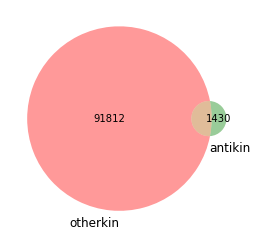

In [30]:
%matplotlib inline
v = venn2(subsets=(len_other-len_both,len_anti-len_both,len_both), set_labels=('otherkin', 'antikin', 'both'))
# v.get_label_by_id('10').set_text('')
# v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('')
# venn2_circles(subsets=(90449-884,2332-884,884))
plt.savefig('/usr2/mamille2/tumblr/otherkin_antikin.png', dpi=400)

In [45]:
def has_tag(text, tags):
    """ Takes in a Tumblr hashtag list and list of tags and returns whether any of them are present """
    
    return any(tag in split_tags(text) for tag in tags)

In [25]:
def has_tag_re(text, regex):
    """ Takes in a Tumblr hashtag text list and regex and returns whether there are any matches """
    
    if not isinstance(text, str):
        return False
    
    else:
        return any(re.match(regex, tag) for tag in split_tags(text))

## Investigate rows with no tags--is newlines in post_content causing error

In [27]:
notags = data[data['post_tags'].map(lambda x: isinstance(x, float))]
len(notags)

260748

In [32]:
# No tag data has *kin somewhere else?
notags_types = {}

# for field in ['post_id', 'body', 'post_caption', 'post_content']:
for field in ['post_id', 'post_title']:
    notags_types[field] = notags[notags[field].map(lambda x: 'kin' in x if isinstance(x, str) else False)]
    print("{0}:\t{1}".format(field, len(notags_types[field])))

post_id:	62706
post_title:	0


In [34]:
pd.set_option('display.max_colwidth', 999)

In [38]:
pd.set_option('display.max_columns', 999)

In [39]:
notags.iloc[:100,:]

,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,updated_time_epoch,source_title,source_url,post_classifier,blog_classifier,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,include_first_tag,include_second_tag,mentions,post_tags,post_content
4,"<p><a class=""photoset_photo rapid-noclick-resp"" href=""http://33.media.tumblr.com/14dfe59ace608b7f746c312290678c48/tumblr_nfrukuVAUo1shdhdjo1_500.gif"" id=""photoset_link_103909364090_1"" data-photoset-index=""1""><img alt="""" src=""https://68.media.tumblr.com/14dfe59ace608b7f746c312290678c48/tumblr_nfrukuVAUo1shdhdjo1_500.gif"" data-pin-description=""Studio Ghibli GIFs"" data-pin-url=""http://studioghifli.com/post/103838762321""/></a></p>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"<p><a class=""photoset_photo rapid-noclick-resp"" href=""http://38.media.tumblr.com/f07b7d73cb549d422475f40122211fd0/tumblr_nfrukuVAUo1shdhdjo2_500.gif"" id=""photoset_link_103909364090_2"" data-photoset-index=""2""><img alt="""" src=""https://68.media.tumblr.com/f07b7d73cb549d422475f40122211fd0/tumblr_nfrukuVAUo1shdhdjo2_500.gif"" data-pin-description=""Studio Ghibli GIFs"" data-pin-url=""http://studioghifli.com/post/103838762321""/></a></p>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"</blockquote>,note_count#1766,slug#arguing-with-otherkin-be-like,source_url#http://equalityinomnicide.tumblr.com/post/104487936288/arguing-with-otherkin-be-like,tags#{(perfect),(anti kin)},source_title#equalityinomnicide]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"<p>They’re really great, especially since they’re a neutral, they go with anything!</p>,photos#[{""caption"":"""",""is_panorama"":false,""alt_sizes"":[{""width"":385,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_400.jpg"",""height"":385},{""width"":250,""url"":""http:\/\/65.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_250.jpg"",""height"":250},{""width"":100,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_100.jpg"",""height"":100},{""width"":75,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_75sq.jpg"",""height"":75}],""original_size"":{""width"":385,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_400.jpg"",""height"":385},""exif"":{}}],note_count#244,slug#grey-nebula-tights-7-theyre-really-great,tags#{(otherkin),(submission),(starkin),(spacekin),(celestialkin)}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,"<p><a href=""https://www.etsy.com/listing/171705731/the-universe-nail-polish-8-ml-vegan-non?ref=sr_gallery_30&amp;ga_search_query=space&amp;ga_order=most_relevant&amp;ga_ship_to=US&amp;ga_min=0&amp;ga_max=20&amp;ga_search_type=handmade&amp;ga_view_type=gallery"">buy it here!</a></p>,photos#[{""caption"":"""",""is_panorama"":false,""alt_sizes"":[{""width"":570,""url"":""http:\/\/65.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_1280.jpg"",""height"":518},{""width"":540,""url"":""http:\/\/65.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_540.jpg"",""height"":491},{""width"":500,""url"":""http:\/\/67.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_500.jpg"",""height"":454},{""width"":400,""url"":""http:\/\/66.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_400.jpg"",""height"":364},{""width"":250,""url"":""http:\/\/66.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_250.jpg"",""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Look at I'm ___ trash

In [ ]:
# Load data
data = pd.read_pickle('/usr2/mamille2/tumblr/data/halfday_text.pkl')
print(data.columns)
print(len(data))

In [ ]:
# Search for I'm ___ trash

trash_re = re.compile(r"(?:I'm|i'm|Im|im).{1,30}(?:trash|Trash|TRASH)")

def trash_present(text):
    """ Return T/F for presence I'm ____ trash """
    
    if not isinstance(text, str):
        return False
    
    if re.search(trash_re, text):
        return True
    else:
        return False

def trash_match(text):
    """ Return match object for I'm ____ trash """
    
    if not isinstance(text, str):
        return None
    
    return re.search(trash_re, text)

In [ ]:
trash_present("I'm star wars trash")

In [ ]:
trash_present("yada")

In [ ]:
trash_data = data[data['body'].map(trash_present)]
len(trash_data)

In [ ]:
trash_data

In [ ]:
type(trash_data.loc[:,'body'])

In [ ]:
pd.set_option('display.max_colwidth', 999)

In [ ]:
trash_data.loc[:,['body']]